<a href="https://colab.research.google.com/github/zbrubaker/portfolio/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

Zachary Brubaker

CS-4430

Project 2 -- Face Detection with EigenFaces

You can access this notebook at:

#Import the Dataset

Import the set of faces, then crop the faces in order to remove the background. 

In [1]:
from sklearn.datasets import fetch_lfw_people
bushPhotos = fetch_lfw_people(min_faces_per_person=530, resize=0.5) 

n_samples, h, w = bushPhotos.images.shape

#Split the Bush Photos into Training and Testing

Use ```train_test_split()``` to split the data

In [2]:
input = bushPhotos.data
output = bushPhotos.target

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(input,output, test_size=0.20)

trainSamples = x_train.shape[0]

Now plot representative training images using matplotlib.

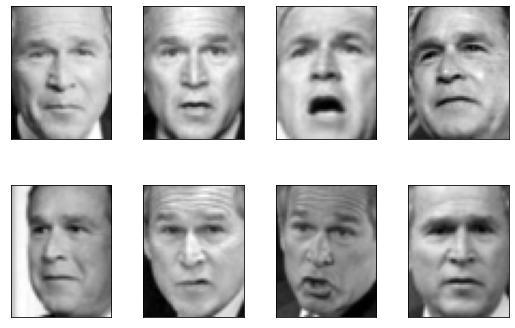

In [3]:
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=2, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())


plot_gallery(x_train, h, w)

#Generate Eigenfaces From the Training Data

We are going to generate EigenFaces using Principle Component Analysis. We will use these EigenFaces for analyzing test datasets.


First, adjust the original data by the mean.

In [4]:
import numpy as np

tempXTrain = x_train
x_train = x_train - np.mean(x_train,axis=0)


Now, generate the covariance matrix for the training data.

In [5]:
A = x_train
A_T = A.transpose()
covarianceMatrix = np.matmul(A_T, A) / (trainSamples - 1)

Then, generate Eigenvalues and EigenVectors from the covariance matrix.

In [6]:
eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

Use the eigen values to order the eigen vectors by highest eigen value. Then, seelect the ```itr``` eigenVectors that make up $95\%$ of the variance for the training data.



In [7]:
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

In [8]:
from pandas.core.internals.base import T

tv = np.sum(eigenValues)
itr = 0
var = 0.0
sum = 0.0
while var < 0.95:
  sum += eigenValues[itr]
  var = sum/tv
  itr = itr + 1

eigenValues = eigenValues[0:itr]
eigenVectors = eigenVectors[:,0:itr]

Now, plot representative EigenFaces from the list.

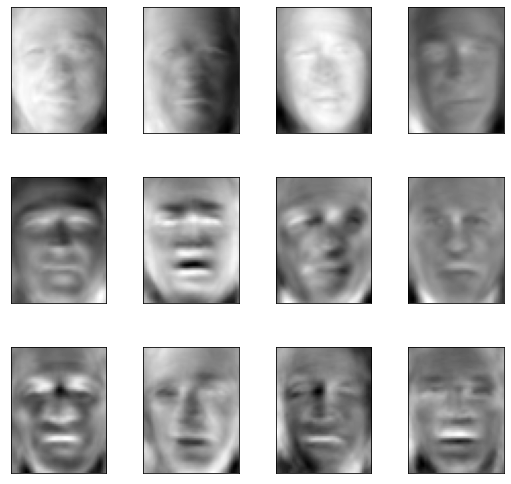

In [9]:
def plot_gallery(eigenVectors, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(eigenVectors[:,i].reshape(h, w), cmap = plt.get_cmap("gray"))
        plt.xticks(())
        plt.yticks(())


plot_gallery(eigenVectors, h, w)

#Test 1: George Bush Classifications

First, multiply the training pictures by the eigenVectors to get their projections into itr-dimensional space. Then, find the average of these itr-dimensional points and save that value for later analysis.

In [10]:
projections = []
for i in range(trainSamples):
  projections.append(np.matmul(x_train[i], eigenVectors))

projections = np.array(projections)

avgPoint = np.average(projections, axis=0)

Now, I am going to find the farthest distance from this average point. I will use this distance as a threshold value in the future. Images that are farther from the averagePoint will not be considered George Bush photos. Images closer than this threshold will be considered George Bush photos.

In [12]:
from numpy.linalg import norm

distances = []

for i in range (x_train.shape[0]):
  difference = norm(avgPoint - np.matmul(x_train[i], eigenVectors))
  distances.append(difference)

print(max(distances))

3621.033


Therefore, I will choose ```3800``` to be the threshold value (this gives some buffer).

In [13]:
threshold = 3800

##Classify the Test Data

We are ready to classify the test data. First, subtract the training mean from the images.

In [14]:
from numpy.linalg import norm

x_test = x_test - np.mean(tempXTrain,axis=0)


Now, analyze each picture in the test dataset and classify whether it is a picture of George Bush.

To do this, find the itr-dimension projection of each image by multiplying the image by the eigenVectors. Then, compare the difference of the image's projection and the average point. Images that are farther from the averagePoint will not be considered George Bush photos. Images closer than this threshold will be considered George Bush photos.

In [23]:
yesCount = 0
noCount = 0
threshold = 3400
distance = 0;

for i in range (x_test.shape[0]):
  difference = norm(avgPoint - np.matmul(x_test[i], eigenVectors))

  if difference < threshold:
    yesCount += 1
  else:
    noCount += 1

print("There are {n} images classified as George Bush.".format(n=yesCount))
print("There are {n} images NOT classified as George Bush.".format(n=noCount))

There are 106 images classified as George Bush.
There are 0 images NOT classified as George Bush.


We can see that all 106 Testing Images were considered George Bush images. The classification algorithm was successful!

#Test 2: Classifying Images as George Bush or Vladimir Putin

First, I need to import all 49 Putin Images. Once I import the faces, I note that Putin has a target value of 12. I use this to grab all images from the dataset with a target value of 12.

In [17]:
faces = fetch_lfw_people(min_faces_per_person=49, resize=0.5) 

In [18]:
putinFaces = []
putinTargets = []
for i in range(faces.data.shape[0]):
  if faces.target[i] == 12:
    putinFaces.append(faces.data[i])
    putinTargets.append(1)
putinFaces = np.array(putinFaces)

Plot representative Putin images from the dataset.

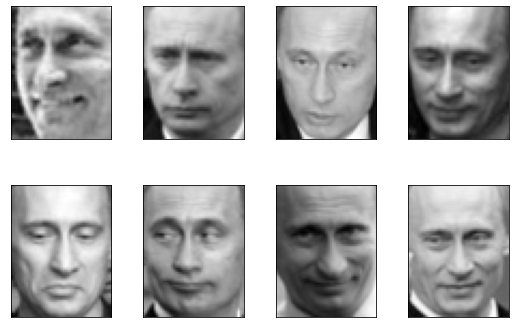

In [19]:
def plot_gallery(images, h, w, n_row=2, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())


plot_gallery(putinFaces, h, w)

We are ready to classify the Putin images. First, subtract the training mean from the images.

In [20]:
mean = np.mean(tempXTrain,axis=0)

putinFaces = putinFaces - mean

Now, analyze each Putin picture and classify whether it is a picture of George Bush.

To do this, find the itr-dimension projection of each image by multiplying the image by the eigenVectors. Then, compare the difference of the image's projection and the average point. Images that are farther from the averagePoint will not be considered George Bush photos. Images closer than this threshold will be considered George Bush photos.

In [22]:
yesCount = 0
noCount = 0

for i in range (putinFaces.shape[0]):
  testDimension = np.matmul(putinFaces[i], eigenVectors)
  difference = norm(avgPoint - testDimension)

  if difference < threshold:
    yesCount += 1
  else:
    noCount += 1

print("There are {n} images classified as George Bush.".format(n=yesCount))
print("There are {n} images NOT classified as George Bush.".format(n=noCount))

There are 49 images classified as George Bush
There are 0 images NOT classified as George Bush


We can see that all 49 Putin images are classified as NOT George Bush, so the classification algorithm was successful!

#Test 3: Plot the most and least "George Bush" Face of Vladimir Putin

To see if a Putin face is like a Bush face, compare difference of image projection from the average point of Bush images. The Putin image that is closest to the average Bush face is most like a Bush face. The Putin image that is farthest from the average Bush Face is least like a Bush face.

##The Most "George Bush" Face of Vladimir Putin

([], <a list of 0 Text major ticklabel objects>)

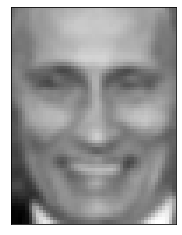

In [28]:
minIndex = -1
minDist = norm(avgPoint - np.matmul(putinFaces[0], eigenVectors))

for i in range (putinFaces.shape[0]):
  difference = norm(avgPoint - np.matmul(putinFaces[i], eigenVectors))
  if difference < minDist:
    minDist = difference
    minIndex = i

plt.figure()
plt.imshow((putinFaces[minIndex] + mean).reshape(h, w), cmap = plt.get_cmap("gray"))
plt.xticks(())
plt.yticks(())

This image is classified as the Putin image that most closely resembles George Bush.

##The Least "George Bush" Face of Vladimir Putin

([], <a list of 0 Text major ticklabel objects>)

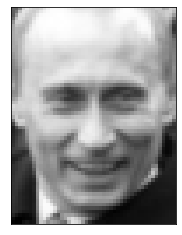

In [29]:
maxIndex = -1
maxDist = -1

for i in range (putinFaces.shape[0]):
  difference = norm(avgPoint - np.matmul(putinFaces[i], eigenVectors))
  if difference > maxDist:
    maxDist = difference
    maxIndex = i

plt.figure()
plt.imshow((putinFaces[maxIndex] + mean).reshape(h, w), cmap = plt.get_cmap("gray"))
plt.xticks(())
plt.yticks(())

This image is classified as the Putin image that least closely resembles George Bush.